In [3]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Append base directory
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
path1p = os.path.dirname(currentdir)
path2p = os.path.dirname(path1p)
libpath = os.path.join(path1p, "lib")

sys.path.insert(0, libpath) 
print("Appended library directory", libpath)

# User libraries
from matlab.matlab_lib import loadmat
from matlab.matlab_yaro_lib import matstruct2dict, merge_dicts, read_lick
from qt_wrapper import gui_fname, gui_fpath

Appended library directory /home/alyosha/work/git/nest-mesoscopic-metric-test/codes/lib


In [4]:
pwd = '/mnt/hifo_scratch1/Yaro/data_for_TE/'
m_file = gui_fname("Select data directory", pwd, filter="Matlab Files (*.m, *.mat)")
print(m_file)
f = loadmat(m_file)

for k,v in f.items():
    if isinstance(v, float) or isinstance(v, int):
        print(k, v)
    else:
        print(k, v.shape)

/mnt/hifo_scratch1/Yaro/data_for_TE/behavior/mtp_12_lick_reaction/mtp_1/mtp_1_2015_06_18_b/RT_264.mat
reaction_time (198,)
early_go_trials (39,)
go_trials (59,)
no_resp_go_trials (0,)
early_nogo_trials (2,)
nogo_trials 144
bot_thresh 2.59
top_thresh 2.64


# Lick

**lick_traces**
* What are the threshold definitions
  * 
* What are the definitions of 2D arrays
  * What are the dimensions (1500 x N) - (sample @ 100Hz(crop to 8s) vs iTrial)
  
**TODO**
- Yaro said some thresholds were off - how to determine good thresholds
- Gaussian broadening + cutoff from the top - get nice continuous lick signal

In [4]:
pwd = '/mnt/hifo_scratch1/Yaro/data_for_TE/'
m_path = gui_fpath("Select data directory", pwd)
f = read_lick(m_path)

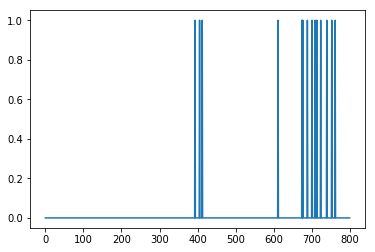

In [5]:
plt.figure()
plt.plot(f['licks_go'][:, 0])
plt.show()

**RT**

* What are the meanings and the dimensions of the files

**NOTE**: Use only one of the RT files, I forgot which one
**TODO**: Ask Yaro what happens in the Miss trials - is the quantity NAN?

In [1]:
print(f)
f['reaction_time'] = 3.0 + f['reaction_time']

NameError: name 'f' is not defined

# Paw

**Trials.m**: 
(iTrial vs iTime (0-6s, sometimes 7Hz (If step=64), else (>250) 30Hz) )

Rescale file to [0, 1]

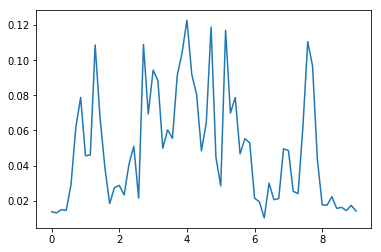

In [5]:
nTrialsPaw, nTimePaw = f['trials'].shape
if nTimePaw == 64:
    freqPaw = 7
elif nTimePaw > 250:
    freqPaw == 30
else:
    raise ValueError("Unexpected number of paw timesteps", nTimePaw)

tPaw = np.linspace(0, (nTimePaw-1) / freqPaw, nTimePaw)

plt.figure()
plt.plot(tPaw, f['trials'][0])
plt.show()

# Whisk

    whiskAngle (1949, 940)
    
(iTime, iTrial) - iTime @ 200Hz(only early mtp) or 40Hz (mtp, 15,16)

- Crop to 8s

- Compute instant velocity instead of position
- 

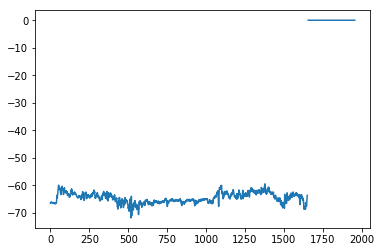

In [96]:
plt.figure()
plt.plot(f['whiskAngle'][:,0])
plt.show()

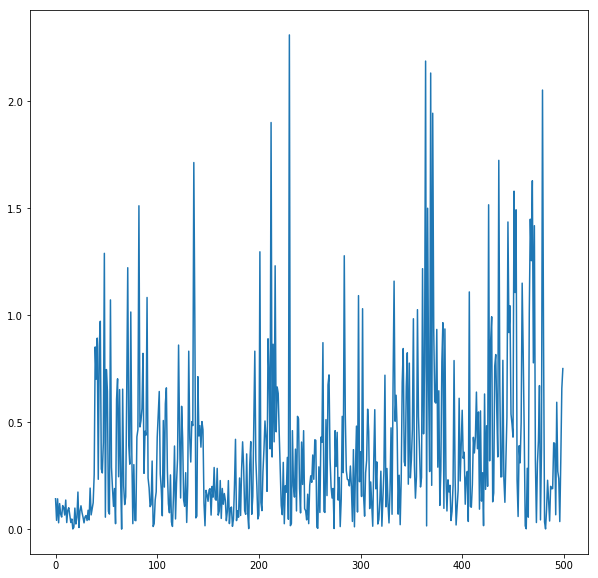

In [103]:
v = [f['whiskAngle'][i, 0] - f['whiskAngle'][i-1, 0] for i in range(1, len(f['whiskAngle'][:, 0]))]
plt.figure(figsize=(10,10))
plt.plot(np.abs(v[:500]))

Open first touch mtp_@#$*&@#$.txt, read column file, 2nd col - first touch in ms